In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preprocessing

In [33]:
# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

# read the mainsample.dta file for further processing 

data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

# Import the mainsample via StataReader to use variable_labels (old version of the read_stata)

data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

# Remove all columns in the dataset for which no labels exist
# Those are mostly columns needed for p-tests and some matrix calculations in
# Stata. The outputted labels are those that are kept in the data

data = data.drop(columns=['CVAxORIGINE_IM_12', 'CVAxZUS_CUCS', 'CVAxZetI', 'C', 'CVA0',\
                          'p_offre1', 'control_manquant', 'ZouI_pred', 'ZouI0', 'ALE_16'])

# Remove sampling weights (within and out of the experiment)

data = data.drop(columns='POIDS_SEL')

# Remove all the centered features

data = data.drop(columns=['FEMME_c', 'a30m_c', 'a3049_c', 'a50p_c', 'dip_aucun_c',\
                          'dip_bepcap_c', 'dip_bac_c', 'dip_bac2p_c', 'recherche_LD_c', 'recherche_TLD_c'])

# Remove all features that are not directly derivable from the CVs or that have missing data

data = data.drop(columns=['RECRUTE', 'REFUSAL', 'codage_cv', 'ORIGINE_IM_1', 'ORIGINE_IM_2',\
                          'ORIGINE_IM_12', 'ID_OFFRE', 'ID_CANDIDAT', 'travail_etranger', 'duree_expro_offre'])

# Remove additional features that seem to bring no value or are unclear in the methodology according to the original paper

data = data.drop(columns=['CV_hesit_', 'CV_hesit', 'CV_note_7p', 'ZetI', 'permis', 'CV_attrayant_'])

# Remove CV coding feature: CV_qualif -> adequate skills 

#data = data.drop(columns=['CV_qualif'])

for key, value in data_labels.items():
    for col in data.columns:
        if key==col:
            # print(key, ':    ', value)
            if len(value)==0 or value.startswith('ID_OFFRE==') or value.startswith('Dummy for local job center'):
                data = data.drop(columns=col)

data['CV_qualif_sup'] = data['CV_qualif_sup'].fillna(0)
data['CV_qualif_inf'] = data['CV_qualif_inf'].fillna(0)
data['PREN_MUSULMAN'] = data['PREN_MUSULMAN'].fillna(0)
data['ZUS_CUCS'] = data['ZUS_CUCS'].fillna(0)
data['recherche_TLD'] = data['recherche_TLD'].fillna(0)

data['etudes_etranger'] = data['etudes_etranger'].fillna(0)
data['langue_anglais'] = data['langue_anglais'].fillna(0)
data['langue_arabe'] = data['langue_arabe'].fillna(0)
data['langue_autres'] = data['langue_autres'].fillna(0)
data['CV_formation_'] = data['CV_formation_'].fillna(0)

# derived from CV_experience_3p

data['CV_experience_'] = data['CV_experience_'].fillna(0.5)

# fill with 1 since missing records are not in the other age groups

data['a26m'] = data['a26m'].fillna(1)

# Assign medium grade for all unknown records
data['CV_note_2'] = data['CV_note_2'].fillna(0)
data['CV_note_3'] = data['CV_note_3'].fillna(1)
data['CV_note_4'] = data['CV_note_4'].fillna(0)
data['CV_note_5'] = data['CV_note_5'].fillna(0)
        
# Normalize remaining columns to values between 0 and 1
# call the min_max_scaling function

data = min_max_scaling(data)

# Create a dataframe for the anonymized and not anonymized data

X = pd.DataFrame()
        
# Assign the interviewed column to our target vector

y = data['ENTRETIEN']

# Drop the Interviewed/hired & anonymized columns (hired is much dependend on the number of jobs available
# and will currently not be considered as target label)

X = data.drop(columns=['CVA', 'ENTRETIEN'])

In [34]:
data_fem = data[data['FEMME']==1].copy()
data_male = data[data['FEMME']==0].copy()

print('average female qualification score:', np.average(data_fem['CV_qualif']))
print('average male qualification score:', np.average(data_male['CV_qualif']))

print('%% of underqualified females: %.2f %%' %(sum(data_fem['CV_qualif_inf'])/data_fem.shape[0]*100))
print('%% of underqualified males: %.2f %%' %(sum(data_male['CV_qualif_inf'])/data_male.shape[0]*100))

print('%% of overqualified females: %.2f %%' %(sum(data_fem['CV_qualif_sup'])/data_fem.shape[0]*100))
print('%% of overqualified males: %.2f %%' %(sum(data_male['CV_qualif_sup'])/data_male.shape[0]*100))

interviewed_dict = {
    'females': data_fem[data_fem['ENTRETIEN']==1].shape[0],
    'males': data_male[data_male['ENTRETIEN']==1].shape[0]
}

m_f_dict = {
    'females': data_fem.shape[0],
    'males': data_male.shape[0]
}

quali_dict = {
    'females': np.average(data_fem['CV_qualif']),
    'males': np.average(data_male['CV_qualif'])
}

uncerquali_dict = {
    'females': sum(data_fem['CV_qualif_inf'])/data_fem.shape[0]*100,
    'males': sum(data_male['CV_qualif_inf'])/data_male.shape[0]*100
       }

overquali_dict = {
    'females': sum(data_fem['CV_qualif_sup'])/data_fem.shape[0]*100,
    'males': sum(data_male['CV_qualif_sup'])/data_male.shape[0]*100
}

average female qualification score: 0.54960024
average male qualification score: 0.5571409
% of underqualified females: 15.30 %
% of underqualified males: 17.79 %
% of overqualified females: 20.21 %
% of overqualified males: 15.66 %


In [35]:
print('correlation between underqualification in the dataset: %.2f' %data['CV_qualif_inf'].corr(data['ENTRETIEN']))
print('correlation between overqualification in the dataset: %.2f' %data['CV_qualif_sup'].corr(data['ENTRETIEN']))

correlation between underqualification in the dataset: -0.05
correlation between overqualification in the dataset: -0.04


<ipython-input-38-7096fb1a8f5c>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(['', 'female', '', 'male'])
<ipython-input-38-7096fb1a8f5c>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(['', 'female', '', 'male'])
<ipython-input-38-7096fb1a8f5c>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(['', 'female', '', 'male'])
<ipython-input-38-7096fb1a8f5c>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 2].set_xticklabels(['', 'female', '', 'male'])
<ipython-input-38-7096fb1a8f5c>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 2].set_xticklabels(['', 'female', '', 'male'])


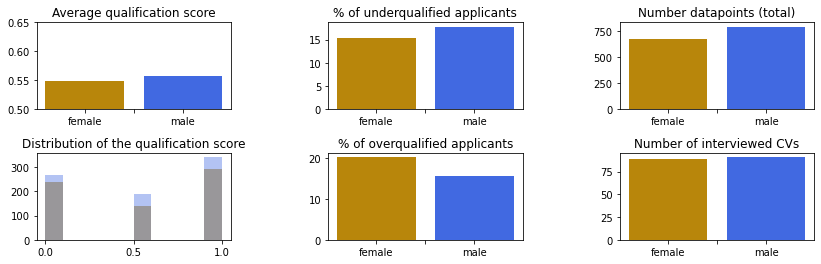

In [38]:
fig, axs = plt.subplots(2, 3)

axs[0, 0].bar(range(len(quali_dict)), list(quali_dict.values()), align='center', color=['darkgoldenrod', 'royalblue'])
axs[0, 0].set_xticklabels(['', 'female', '', 'male'])
axs[0, 0].set_ylim(0.5, 0.65)
axs[0, 0].set_title('Average qualification score')

axs[1, 0].hist(data_fem['CV_qualif'], alpha=.6, color='darkgoldenrod')
axs[1, 0].hist(data_male['CV_qualif'], alpha=.4, color='royalblue')
axs[1, 0].set_xticks([0, 0.5, 1])
axs[1, 0].set_title('Distribution of the qualification score')

axs[0, 1].bar(range(len(uncerquali_dict)), list(uncerquali_dict.values()), align='center', color=['darkgoldenrod', 'royalblue'])
axs[0, 1].set_xticklabels(['', 'female', '', 'male'])
axs[0, 1].set_title('% of underqualified applicants')

axs[1, 1].bar(range(len(overquali_dict)), list(overquali_dict.values()), align='center', color=['darkgoldenrod', 'royalblue'])
axs[1, 1].set_xticklabels(['', 'female', '', 'male'])
axs[1, 1].set_title('% of overqualified applicants')

axs[0, 2].bar(range(len(m_f_dict)), list(m_f_dict.values()), align='center', color=['darkgoldenrod', 'royalblue'])
axs[0, 2].set_xticklabels(['', 'female', '', 'male'])
axs[0, 2].set_title('Number datapoints (total)')


axs[1, 2].bar(range(len(interviewed_dict)), list(interviewed_dict.values()), align='center', color=['darkgoldenrod', 'royalblue'])
axs[1, 2].set_xticklabels(['', 'female', '', 'male'])
axs[1, 2].set_title('Number of interviewed CVs')


plt.subplots_adjust(left=-0.9, bottom=None, right=None, top=None, wspace=0.5, hspace=.50)

**Observation**:
* The average qualification score is slightly higher for male than for female
* Without upsampling the distribution of qualification score is very similar for both genders

* On the other side there are more underqualified male and more overqualified females. Both features under and overqualified are shown to be negatively correlated with our label interviewed.

* The number of applicants interviewed is significantly lower than the total number of applicants, where roughly the same. At the same it seems that proportionally females are more interviewed 

* Results from the original study also found that significant evidence (p-value < 0.05) that the variable 'gender' has influence on the decision of hiring (Behaghel et al. 2015).

## Publication bibliography
* Behaghel, Luc; Crépon, Bruno; Le Barbanchon, Thomas (2015): Unintended Effects of Anonymous Résumés. In American Economic Journal: Applied Economics 7 (3), pp. 1–27. DOI: 10.1257/app.20140185.
